<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Generative adversarial networks


В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/My Drive/folder'

faces_dataset_small.zip  file.zip


In [ ]:
!cp '/content/drive/MyDrive/folder/faces_dataset_small.zip' file.zip

In [ ]:
!unzip 'file.zip' -d 'data'

In [ ]:
DATA_DIR = '/content/drive/MyDrive/data/'

In [ ]:
image_size = 512
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    #tt.CenterCrop(image_size),
    tt.ToTensor(),
    #tt.Normalize(*stats)
    ]))
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return train_dl


In [ ]:
train_dl = get_dataloader(image_size, batch_size)

In [ ]:
def denorm(img_tensors):
    return img_tensors #* stats[1][0] + stats[0][0]
def show_batch_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_batch_images(images, nmax)
        break

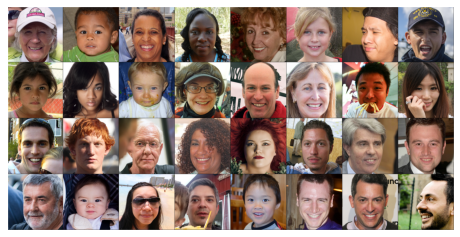

In [ ]:
show_batch(train_dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Linear(in_features=841, out_features=1),
    nn.Sigmoid())
discriminator = to_device(discriminator, device)

In [ ]:
from torchsummary import summary
summary(model["discriminator"], (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           3,072
       BatchNorm2d-2         [-1, 64, 256, 256]             128
         LeakyReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 128, 128]         131,072
       BatchNorm2d-5        [-1, 128, 128, 128]             256
         LeakyReLU-6        [-1, 128, 128, 128]               0
            Conv2d-7          [-1, 256, 64, 64]         524,288
       BatchNorm2d-8          [-1, 256, 64, 64]             512
         LeakyReLU-9          [-1, 256, 64, 64]               0
           Conv2d-10          [-1, 512, 32, 32]       2,097,152
      BatchNorm2d-11          [-1, 512, 32, 32]           1,024
        LeakyReLU-12          [-1, 512, 32, 32]               0
           Conv2d-13            [-1, 1, 29, 29]           8,192
          Flatten-14                  [

In [ ]:
latent_size = 1024 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    # out: 64 x 128 x 128

    nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(8),
    nn.ReLU(True),
    # out: 64 x 256 x 256

    nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 512 x 512
)

In [ ]:
from torchsummary import summary
summary(model["generator"], (1024, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       8,388,608
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13           [-1, 32, 64, 64]          32,768
      BatchNorm2d-14           [-1, 32,

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
import torch.nn as nn

In [ ]:
lr = 0.0001

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

torch.Size([64, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


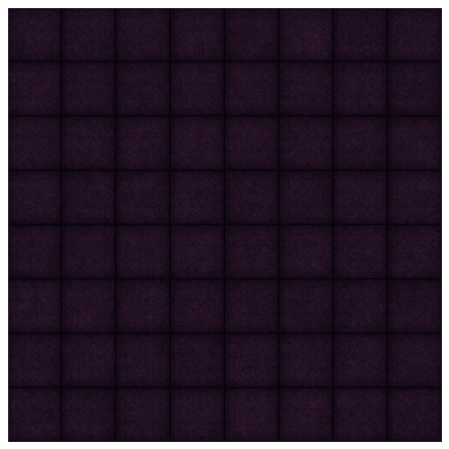

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_batch_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(image_size, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 40

In [ ]:
history = fit(model, criterion, epochs, lr)

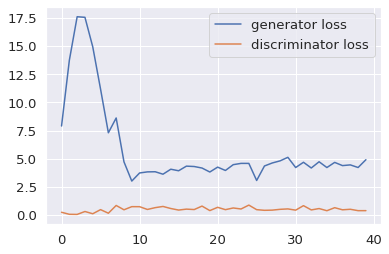

In [ ]:
plt.plot(history[0], label="generator loss")
plt.plot(history[1], label="discriminator loss")
plt.legend()

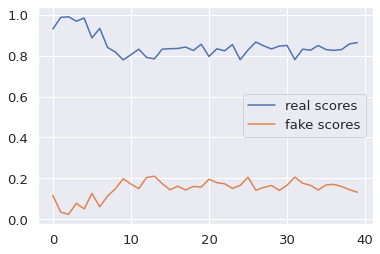

In [ ]:
plt.plot(history[2], label="real scores")
plt.plot(history[3], label="fake scores")
plt.legend()

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Все как и должно быть real score достигает максимума, а потом падает и становится потчи постоянным, fake score сначала падает, потом становится почти постоянным.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

Из случайных векторов

In [ ]:
n_images = 10
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [ ]:
def show_images(fake_images):
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=10).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


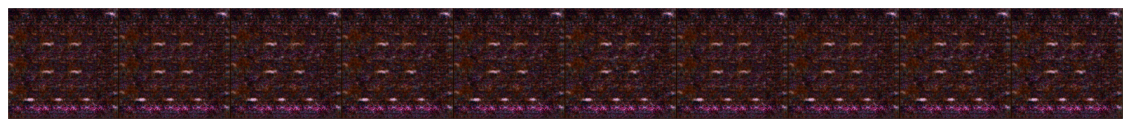

In [ ]:
show_images(fake_images)

Из папки generated

In [ ]:
def show_images(generated):
    generated_img = generated[:, :, [2, 1, 0]]
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(generated_img)

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
show_images(generated_img)

Как вам качество получившихся изображений?
Лучше чем VAE, но все равно не очень хорошо.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
def fake_generator(latent_tensors):
    fake_images = model["generator"](latent_tensors).cpu().detach()
    return fake_images

In [ ]:
n_images = 3100
fake_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = fake_generator(fake_latent)
fake_labels = torch.zeros(n_images)
true_labels = torch.ones(3100)

In [ ]:
fake_images.size()

torch.Size([3100, 3, 64, 64])

In [ ]:
all_dl = get_dataloader(image_size, batch_size=3100)

In [ ]:
real_images=torch.zeros_like(fake_images)
real_images.size()

torch.Size([3100, 3, 64, 64])

In [ ]:
for batch in all_dl:
    real_images=batch[0]
    break

In [ ]:
real_images.size()

torch.Size([3100, 3, 64, 64])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNC_sklearn
from sklearn.model_selection import LeaveOneOut

In [ ]:
X=torch.cat((fake_images, real_images))
y=torch.cat((fake_labels, true_labels))

In [ ]:
X = X.view(6200, -1)

In [ ]:
from sklearn.decomposition import PCA
transformer=PCA(n_components=64).fit_transform(X)

In [ ]:
transformer.shape

(6200, 64)

In [ ]:
scores=[]

In [ ]:
loo = LeaveOneOut()
loo.get_n_splits(transformer)
for train_index, test_index in loo.split(transformer):
    X_train, X_test = transformer[train_index], transformer[test_index]
    y_train, y_test = y[train_index], y[test_index]
    KNC = KNC_sklearn(n_neighbors=1)
    KNC.fit(X_train, y_train)
    score = KNC.score(X_test, y_test)
    scores.append(score)

In [ ]:
np.mean(np.array(scores))

0.978225806451613

Плохо. Попробуем по-другому: будем считать метрику по батчам, а не по всему датасету сразу(иначе вышло бы где-то 30 часов..).

In [ ]:
X.size()

torch.Size([6200, 12288])

In [ ]:
Y=y.view(-1,1)
Y.size()

torch.Size([6200, 1])

In [ ]:
Xy=torch.cat((X,Y),1)
Xy.size()

torch.Size([6200, 12289])

In [ ]:
all_dl = DataLoader(Xy, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
all_dl = DeviceDataLoader(all_dl, device)

In [ ]:
# Подготовка даталоадера
for batch in all_dl:
    x_batch=batch[:, :-1]
    y_batch=batch[:, -1:].view(-1)
    print(x_batch.size())
    print(y_batch.size())
    break

torch.Size([128, 12288])
torch.Size([128])


In [ ]:
scores=[]

In [ ]:
for batch in all_dl:
    x_batch=batch[:, :-1]
    y_batch=batch[:, -1:].view(-1)
    loo = LeaveOneOut()
    loo.get_n_splits(x_batch)
    for train_index, test_index in loo.split(x_batch):
        X_train, X_test = x_batch[train_index], x_batch[test_index]
        y_train, y_test = y_batch[train_index], y_batch[test_index]
        KNC = KNC_sklearn(n_neighbors=1)
        KNC.fit(X_train.cpu(), y_train.cpu())
        score = KNC.score(X_test.cpu(), y_test.cpu())
        scores.append(score)
np.mean(np.array(scores))

0.8204838709677419

Уже лучше.

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?


Хотели получить accuracy 50% потому что распределения датасета и генератора должны совпадать. Получили 82%

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Сначала используем сжатие с помощью CPA (transformer), затем с помощью TSNE сожмем до размерности 2(иначе получается весьма долго)

In [ ]:
from sklearn.decomposition import PCA
transformer=PCA(n_components=64).fit_transform(X)

In [ ]:
from sklearn.manifold import TSNE
new_x = TSNE(n_components=2).fit_transform(transformer)

In [ ]:
new_x.shape

(6200, 2)

In [ ]:
new_x=new_x.T

In [ ]:
new_x.shape

(2, 6200)

In [ ]:
fake_x=new_x[0][:3100]
real_x=new_x[0][-3100:]
fake_y=new_x[1][:3100]
real_y=new_x[1][-3100:]

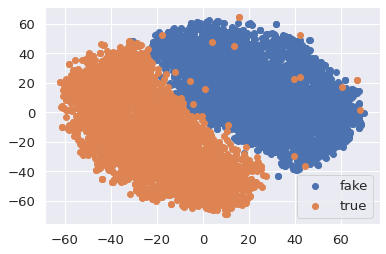

In [ ]:
plt.scatter(fake_x, fake_y, label="fake")
plt.scatter(real_x, real_y, label="true")
plt.legend()

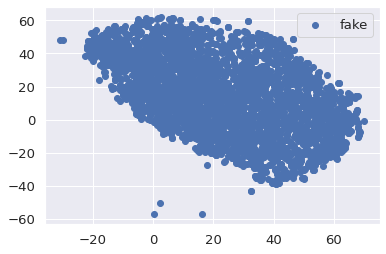

In [ ]:
plt.scatter(fake_x, fake_y, label="fake")
plt.legend()

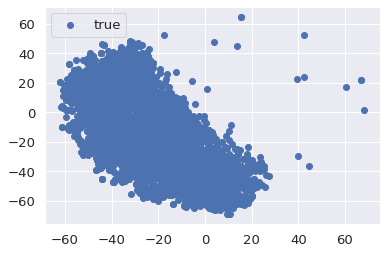

In [ ]:
plt.scatter(real_x, real_y, label="true")
plt.legend()

Прокомментируйте получившийся результат:

Достаточно сильное разделение.. это плохо